# Experiment 5: Temperature Validation for Noisy Models

**Goal:** Validate that T* = √(1+α) is optimal for noisy language models.

**Key Fix:** Temperature only affects SAMPLING, not greedy decoding!
- `argmax(logits/T) = argmax(logits)` for any T > 0
- Must use `do_sample=True` for temperature to have any effect

**Experiments:**
- 5a: Single-token probability analysis
- 5b: Sequence generation with sampling
- 5c: GSM8K accuracy evaluation

In [1]:
# ============================================================
# UTILITIES - Run this cell first!
# ============================================================

"""
Utility functions for quantization noise and temperature experiments.
"""

import torch
import torch.nn.functional as F
import numpy as np
from contextlib import contextmanager
import re
from transformers import AutoModelForCausalLM, AutoTokenizer


# =============================================================================
# Noise Injection
# =============================================================================

@contextmanager
def weight_noise_context(model, noise_scale):
    """
    Context manager that adds Gaussian noise to model weights.
    Noise is removed when exiting the context.
    """
    original_weights = {}
    
    try:
        # Add noise to weights
        for name, param in model.named_parameters():
            if 'weight' in name:
                original_weights[name] = param.data.clone()
                noise = torch.randn_like(param.data) * noise_scale * param.data.std()
                param.data.add_(noise)
        
        yield model, original_weights
        
    finally:
        # Restore original weights
        for name, param in model.named_parameters():
            if name in original_weights:
                param.data.copy_(original_weights[name])


@contextmanager  
def activation_noise_context(model, noise_scale):
    """
    Context manager that adds Gaussian noise to activations via forward pre-hooks.
    Uses INPUT hooks (pre-hook) for realistic quantization simulation.
    """
    handles = []
    
    def make_hook(scale):
        def hook(module, args, kwargs):
            if len(args) > 0:
                x = args[0]
                noise = torch.randn_like(x) * scale * x.std()
                noisy_x = x + noise
                return (noisy_x,) + args[1:], kwargs
            return args, kwargs
        return hook
    
    try:
        # Register pre-hooks on linear layers
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                handle = module.register_forward_pre_hook(make_hook(noise_scale), with_kwargs=True)
                handles.append(handle)
        
        yield model, handles
        
    finally:
        # Remove hooks
        for handle in handles:
            handle.remove()


@contextmanager
def combined_noise_context(model, weight_noise_scale, activation_noise_scale):
    """
    Context manager that adds both weight and activation noise.
    """
    handles = []
    original_weights = {}
    
    def make_hook(scale):
        def hook(module, args, kwargs):
            if len(args) > 0:
                x = args[0]
                noise = torch.randn_like(x) * scale * x.std()
                noisy_x = x + noise
                return (noisy_x,) + args[1:], kwargs
            return args, kwargs
        return hook
    
    try:
        # Add weight noise
        for name, param in model.named_parameters():
            if 'weight' in name:
                original_weights[name] = param.data.clone()
                noise = torch.randn_like(param.data) * weight_noise_scale * param.data.std()
                param.data.add_(noise)
        
        # Add activation hooks
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                handle = module.register_forward_pre_hook(make_hook(activation_noise_scale), with_kwargs=True)
                handles.append(handle)
        
        yield model, (original_weights, handles)
        
    finally:
        # Restore weights
        for name, param in model.named_parameters():
            if name in original_weights:
                param.data.copy_(original_weights[name])
        
        # Remove hooks
        for handle in handles:
            handle.remove()


# =============================================================================
# Alpha (noise-to-signal ratio) Measurement
# =============================================================================

def compute_alpha(clean_logits, noisy_logits):
    """
    Compute noise-to-signal ratio α = σ²_noise / τ²_signal
    
    Args:
        clean_logits: Logits from clean model
        noisy_logits: Logits from noisy model
    
    Returns:
        dict with tau_sq, sigma_sq, alpha, t_star
    """
    diff = noisy_logits - clean_logits
    tau_sq = clean_logits.var().item()
    sigma_sq = diff.var().item()
    alpha = sigma_sq / tau_sq if tau_sq > 0 else 0
    t_star = np.sqrt(1 + alpha)
    
    return {
        'tau_sq': tau_sq,
        'sigma_sq': sigma_sq,
        'alpha': alpha,
        't_star': t_star
    }


def get_logits(model, tokenizer, prompt):
    """Get logits for next token prediction."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(inputs.input_ids)
    return outputs.logits[0, -1, :].float()


# =============================================================================
# Generation with Temperature (FIXED - uses sampling!)
# =============================================================================

def generate_with_temperature(model, tokenizer, prompt, temperature=1.0, 
                              max_new_tokens=512, do_sample=True, seed=None):
    """
    Generate text with proper temperature scaling.
    
    IMPORTANT: Temperature only affects sampling, not argmax!
    - do_sample=True: temperature scales probabilities before sampling
    - do_sample=False: temperature has NO effect (argmax is scale-invariant)
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt: Input prompt string
        temperature: Sampling temperature (only works with do_sample=True)
        max_new_tokens: Maximum tokens to generate
        do_sample: If True, sample from distribution. If False, greedy (T ignored!)
        seed: Random seed for reproducibility
    
    Returns:
        generated_text: The generated string
        generated_tokens: List of token ids
    """
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_ids = inputs.input_ids.clone()
    generated_tokens = []
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            outputs = model(input_ids)
            logits = outputs.logits[0, -1, :].float()
            
            if do_sample and temperature > 0:
                # Apply temperature and sample
                scaled_logits = logits / temperature
                probs = F.softmax(scaled_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
            else:
                # Greedy - temperature has NO effect!
                next_token = logits.argmax().item()
            
            generated_tokens.append(next_token)
            input_ids = torch.cat([input_ids, torch.tensor([[next_token]]).to(model.device)], dim=1)
            
            if next_token == tokenizer.eos_token_id:
                break
    
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text, generated_tokens


def generate_greedy(model, tokenizer, prompt, max_new_tokens=512):
    """
    Generate text with greedy decoding (deterministic).
    Temperature has NO effect on greedy decoding!
    """
    return generate_with_temperature(
        model, tokenizer, prompt, 
        temperature=1.0, max_new_tokens=max_new_tokens, 
        do_sample=False
    )


# =============================================================================
# Evaluation Metrics
# =============================================================================

def evaluate_temperature_effect(clean_logits, noisy_logits, temperatures):
    """
    Evaluate how different temperatures affect the noisy distribution.
    
    For each temperature, computes:
    - KL divergence from clean distribution
    - JS divergence (symmetric)
    - Probability of correct (clean's argmax) token
    - Cross entropy
    
    Args:
        clean_logits: Logits from clean model
        noisy_logits: Logits from noisy model  
        temperatures: List of temperatures to test
    
    Returns:
        dict mapping temperature to metrics
    """
    clean_probs = F.softmax(clean_logits, dim=-1)
    correct_token = clean_logits.argmax().item()
    
    results = {}
    
    for temp in temperatures:
        noisy_probs = F.softmax(noisy_logits / temp, dim=-1)
        
        # KL divergence: KL(clean || noisy)
        kl_div = F.kl_div(noisy_probs.log(), clean_probs, reduction='sum').item()
        
        # JS divergence (symmetric)
        m_probs = 0.5 * (clean_probs + noisy_probs)
        js_div = 0.5 * F.kl_div(m_probs.log(), clean_probs, reduction='sum').item() + \
                 0.5 * F.kl_div(m_probs.log(), noisy_probs, reduction='sum').item()
        
        # Probability of correct token
        prob_correct = noisy_probs[correct_token].item()
        
        # Cross entropy
        cross_entropy = -(clean_probs * noisy_probs.log()).sum().item()
        
        results[temp] = {
            'kl_div': kl_div,
            'js_div': js_div,
            'prob_correct': prob_correct,
            'cross_entropy': cross_entropy,
        }
    
    return results


# =============================================================================
# GSM8K Helpers
# =============================================================================

def extract_answer(text):
    """Extract numerical answer from model output."""
    # Look for #### pattern (GSM8K format)
    match = re.search(r'####\s*([\d,\.\-]+)', text)
    if match:
        return match.group(1).replace(',', '')
    
    # Look for 'answer is X' pattern
    match = re.search(r'answer is[:\s]*([\d,\.\-]+)', text.lower())
    if match:
        return match.group(1).replace(',', '')
    
    # Look for boxed answer (common in reasoning models)
    match = re.search(r'\\boxed\{([\d,\.\-]+)\}', text)
    if match:
        return match.group(1).replace(',', '')
    
    # Look for last number in text
    numbers = re.findall(r'[\d,]+\.?\d*', text)
    if numbers:
        return numbers[-1].replace(',', '')
    
    return None


def extract_ground_truth(answer_text):
    """Extract ground truth from GSM8K answer format."""
    match = re.search(r'####\s*([\d,\.\-]+)', answer_text)
    if match:
        return match.group(1).replace(',', '')
    return None


def check_answer(pred, truth):
    """Check if predicted answer matches ground truth."""
    if pred is None or truth is None:
        return False
    try:
        return abs(float(pred) - float(truth)) < 0.01
    except:
        return pred.strip() == truth.strip()


def format_gsm8k_prompt(question, tokenizer, use_chat_template=True):
    """Format GSM8K question as prompt."""
    if use_chat_template and hasattr(tokenizer, 'apply_chat_template'):
        messages = [
            {"role": "user", "content": f"Solve this math problem step by step:\n{question}"}
        ]
        return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    else:
        return f"Question: {question}\nLet me solve this step by step:\n"


# =============================================================================
# Reproducibility
# =============================================================================

def set_seed(seed):
    """Set random seed for reproducibility."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# =============================================================================
# Sanity Checks
# =============================================================================

def verify_noise_injection(model, tokenizer, noise_ctx_fn, noise_scale, prompt="Hello"):
    """
    Verify that noise injection is actually working.
    
    Returns True if noise is being applied (outputs differ).
    """
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    
    # Clean output
    with torch.no_grad():
        clean_out = model(inputs.input_ids).logits[0, -1, :]
    
    # Noisy outputs (should differ each time)
    noisy_outs = []
    for _ in range(3):
        with noise_ctx_fn(model, noise_scale) as (noisy_model, _):
            with torch.no_grad():
                noisy_out = noisy_model(inputs.input_ids).logits[0, -1, :]
                noisy_outs.append(noisy_out.clone())
    
    # Check that noisy differs from clean
    diff_from_clean = (noisy_outs[0] - clean_out).abs().mean().item()
    
    # Check that noisy outputs differ from each other (stochastic)
    diff_between_noisy = (noisy_outs[0] - noisy_outs[1]).abs().mean().item()
    
    print(f"Mean diff from clean: {diff_from_clean:.4f}")
    print(f"Mean diff between noisy runs: {diff_between_noisy:.4f}")
    
    is_working = diff_from_clean > 0.01 and diff_between_noisy > 0.01
    print(f"Noise injection working: {is_working}")
    
    return is_working


In [2]:
# Load model - UPDATE THIS FOR YOUR MODEL
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"  # Change as needed

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,  # Full precision for noise experiments
    device_map="auto"
)
model.eval()
print(f"Model loaded on {model.device}")

Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda:0


In [3]:
# Verify noise injection is working
print("Verifying noise injection...")
print("\nActivation noise:")
verify_noise_injection(model, tokenizer, activation_noise_context, 0.05)
print("\nWeight noise:")
verify_noise_injection(model, tokenizer, weight_noise_context, 0.05)

Verifying noise injection...

Activation noise:
Mean diff from clean: 2.1996
Mean diff between noisy runs: 2.4004
Noise injection working: True

Weight noise:
Mean diff from clean: 0.3813
Mean diff between noisy runs: 0.6199
Noise injection working: True


True

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)
print(f"Seed set to {SEED}")

Seed set to 42


## Experiment 5a: Single-Token Probability Analysis

Measure how temperature affects the probability distribution for a single next token.
This doesn't require sampling - we just look at the probabilities.

In [ ]:
# Test prompts
TEST_PROMPTS = [
    "What is 2 + 2? The answer is",
    "The capital of France is",
    "Count: 1, 2, 3, 4,",
    "Hello, how are",
]

# Get clean logits for each prompt
print("Getting clean logits...")
clean_logits = {}
for prompt in TEST_PROMPTS:
    clean_logits[prompt] = get_logits(model, tokenizer, prompt)
print(f"Got logits for {len(TEST_PROMPTS)} prompts")

In [ ]:
# Measure α for different noise levels
noise_levels = [0.01, 0.02, 0.05, 0.1]
temperatures = [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45]

results_5a = []

for noise_scale in noise_levels:
    print(f"\nNoise scale: {noise_scale}")
    
    for prompt in TEST_PROMPTS:
        with activation_noise_context(model, noise_scale) as (noisy_model, _):
            noisy_logits = get_logits(noisy_model, tokenizer, prompt)
        
        # Compute α
        alpha_result = compute_alpha(clean_logits[prompt], noisy_logits)
        
        # Evaluate temperatures
        temp_results = evaluate_temperature_effect(
            clean_logits[prompt], noisy_logits, temperatures
        )
        
        # Find best T for each metric
        best_t_prob = max(temperatures, key=lambda t: temp_results[t]['prob_correct'])
        best_t_kl = min(temperatures, key=lambda t: temp_results[t]['kl_div'])
        
        results_5a.append({
            'noise_scale': noise_scale,
            'prompt': prompt[:30],
            'alpha': alpha_result['alpha'],
            't_star_predicted': alpha_result['t_star'],
            'best_t_prob': best_t_prob,
            'best_t_kl': best_t_kl,
            'prob_at_t1': temp_results[1.0]['prob_correct'],
            'prob_at_tstar': temp_results[min(temperatures, key=lambda t: abs(t - alpha_result['t_star']))]['prob_correct'],
        })

print("\nDone!")

In [ ]:
# Summary table
print("\n" + "="*90)
print("EXPERIMENT 5a: Single-Token Analysis")
print("="*90)
print(f"{'Noise':<8} {'Prompt':<32} {'α':<8} {'T*pred':<8} {'BestT(prob)':<12} {'BestT(KL)':<10}")
print("-"*90)

for r in results_5a:
    print(f"{r['noise_scale']:<8} {r['prompt']:<32} {r['alpha']:<8.3f} {r['t_star_predicted']:<8.3f} "
          f"{r['best_t_prob']:<12.2f} {r['best_t_kl']:<10.2f}")

In [ ]:
# Plot: prob_correct vs temperature for different noise levels
fig, axes = plt.subplots(1, len(noise_levels), figsize=(4*len(noise_levels), 4))

for idx, noise_scale in enumerate(noise_levels):
    ax = axes[idx]
    
    # Get one example
    prompt = TEST_PROMPTS[0]
    with activation_noise_context(model, noise_scale) as (noisy_model, _):
        noisy_logits = get_logits(noisy_model, tokenizer, prompt)
    
    alpha_result = compute_alpha(clean_logits[prompt], noisy_logits)
    temp_results = evaluate_temperature_effect(clean_logits[prompt], noisy_logits, temperatures)
    
    probs = [temp_results[t]['prob_correct'] for t in temperatures]
    
    ax.plot(temperatures, probs, 'b-', linewidth=2)
    ax.axvline(x=alpha_result['t_star'], color='red', linestyle='--', label=f"T*={alpha_result['t_star']:.2f}")
    ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('P(correct token)')
    ax.set_title(f'Noise={noise_scale}, α={alpha_result["alpha"]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('exp5a_prob_vs_temp.png', dpi=150)
plt.show()

## Experiment 5b: Sequence Generation with Sampling

**CRITICAL:** Temperature only affects sampling!

We generate sequences WITH SAMPLING and compare to clean model reference.

In [ ]:
def evaluate_sequence_sampling(model, tokenizer, prompt, clean_tokens, 
                                noise_ctx_fn, noise_scale, temperature,
                                num_samples=10, max_tokens=30, seed=None):
    """
    Evaluate sequence generation with SAMPLING (not greedy!).
    Temperature actually affects the output here.
    """
    matches = []
    
    for i in range(num_samples):
        # Set seed for this sample
        if seed is not None:
            set_seed(seed + i)
        
        with noise_ctx_fn(model, noise_scale) as (noisy_model, _):
            _, gen_tokens = generate_with_temperature(
                noisy_model, tokenizer, prompt,
                temperature=temperature,
                max_new_tokens=max_tokens,
                do_sample=True,  # IMPORTANT!
                seed=seed + i if seed else None
            )
        
        # Compare to clean
        min_len = min(len(gen_tokens), len(clean_tokens))
        match_count = sum(1 for j in range(min_len) if gen_tokens[j] == clean_tokens[j])
        matches.append(match_count / len(clean_tokens) if clean_tokens else 0)
    
    return np.mean(matches), np.std(matches)

In [ ]:
# Generate clean reference sequences (greedy)
print("Generating clean reference sequences (greedy)...")
clean_sequences = {}

for prompt in TEST_PROMPTS:
    _, tokens = generate_with_temperature(
        model, tokenizer, prompt,
        max_new_tokens=30,
        do_sample=False  # Greedy for reference
    )
    clean_sequences[prompt] = tokens
    decoded = tokenizer.decode(tokens[:10])
    print(f"  {prompt[:25]}... → {decoded}...")

In [ ]:
# Test sequence generation with different temperatures
noise_levels_seq = [0.02, 0.05]
temperatures_seq = [0.8, 1.0, 1.1, 1.2, 1.3, 1.5]
num_samples = 10

results_5b = []

for noise_scale in noise_levels_seq:
    print(f"\nNoise: {noise_scale}")
    
    # First compute α for this noise level
    prompt = TEST_PROMPTS[0]
    with activation_noise_context(model, noise_scale) as (noisy_model, _):
        noisy_logits = get_logits(noisy_model, tokenizer, prompt)
    alpha_result = compute_alpha(clean_logits[prompt], noisy_logits)
    t_star = alpha_result['t_star']
    
    print(f"  α = {alpha_result['alpha']:.3f}, T* = {t_star:.3f}")
    
    for temp in temperatures_seq:
        all_matches = []
        
        for prompt in TEST_PROMPTS:
            mean_match, std_match = evaluate_sequence_sampling(
                model, tokenizer, prompt, clean_sequences[prompt],
                activation_noise_context, noise_scale, temp,
                num_samples=num_samples, max_tokens=30, seed=SEED
            )
            all_matches.append(mean_match)
        
        avg_match = np.mean(all_matches)
        print(f"  T={temp}: match={avg_match:.3f}")
        
        results_5b.append({
            'noise_scale': noise_scale,
            'alpha': alpha_result['alpha'],
            't_star': t_star,
            'temperature': temp,
            'match_rate': avg_match,
        })

In [ ]:
# Plot results
fig, axes = plt.subplots(1, len(noise_levels_seq), figsize=(6*len(noise_levels_seq), 5))

for idx, noise_scale in enumerate(noise_levels_seq):
    ax = axes[idx]
    
    data = [r for r in results_5b if r['noise_scale'] == noise_scale]
    temps = [r['temperature'] for r in data]
    matches = [r['match_rate'] for r in data]
    t_star = data[0]['t_star']
    alpha = data[0]['alpha']
    
    ax.plot(temps, matches, 'bo-', linewidth=2, markersize=8)
    ax.axvline(x=t_star, color='red', linestyle='--', linewidth=2, label=f'T*={t_star:.2f}')
    ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5, label='T=1.0')
    
    best_t = temps[np.argmax(matches)]
    ax.axvline(x=best_t, color='green', linestyle=':', linewidth=2, label=f'Best={best_t:.2f}')
    
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Token Match Rate')
    ax.set_title(f'Noise={noise_scale}, α={alpha:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('exp5b_sequence_sampling.png', dpi=150)
plt.show()

print("\nSUMMARY:")
for noise_scale in noise_levels_seq:
    data = [r for r in results_5b if r['noise_scale'] == noise_scale]
    best = max(data, key=lambda x: x['match_rate'])
    print(f"  Noise={noise_scale}: Best T={best['temperature']}, T*={best['t_star']:.2f}, Match={best['match_rate']:.3f}")

## Experiment 5c: GSM8K Evaluation

Real task accuracy on math reasoning.

In [5]:
from datasets import load_dataset

gsm8k = load_dataset('gsm8k', 'main', split='test')
print(f"Loaded {len(gsm8k)} GSM8K examples")

Loaded 1319 GSM8K examples


In [6]:
def evaluate_gsm8k_sampling(model, tokenizer, examples, noise_ctx_fn=None, 
                            noise_scale=0.0, temperature=1.0, 
                            max_new_tokens=1024, num_samples=1, seed=None):
    """
    Evaluate on GSM8K with proper sampling.
    """
    results = []
    outputs = []
    
    for idx, ex in enumerate(examples):
        question = ex['question']
        ground_truth = extract_ground_truth(ex['answer'])
        
        prompt = format_gsm8k_prompt(question, tokenizer, use_chat_template=True)
        
        correct_count = 0
        sample_responses = []
        
        for s in range(num_samples):
            sample_seed = seed + idx * 100 + s if seed else None
            
            if noise_ctx_fn and noise_scale > 0:
                with noise_ctx_fn(model, noise_scale) as (noisy_model, _):
                    response, _ = generate_with_temperature(
                        noisy_model, tokenizer, prompt,
                        temperature=temperature,
                        max_new_tokens=max_new_tokens,
                        do_sample=True,
                        seed=sample_seed
                    )
            else:
                response, _ = generate_with_temperature(
                    model, tokenizer, prompt,
                    temperature=temperature,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    seed=sample_seed
                )
            
            pred = extract_answer(response)
            is_correct = check_answer(pred, ground_truth)
            
            if is_correct:
                correct_count += 1
            
            sample_responses.append({
                'response': response[:500],
                'pred': pred,
                'correct': is_correct
            })
        
        results.append({
            'idx': idx,
            'ground_truth': ground_truth,
            'accuracy': correct_count / num_samples
        })
        
        outputs.append({
            'idx': idx,
            'question': question[:100],
            'ground_truth': ground_truth,
            'samples': sample_responses
        })
        
        if (idx + 1) % 5 == 0:
            print(f"  {idx+1}/{len(examples)} done...")
    
    accuracy = np.mean([r['accuracy'] for r in results])
    return accuracy, results, outputs

In [8]:
# Evaluate on subset
set_seed(SEED)
num_examples = 20
test_examples = [gsm8k[i] for i in range(num_examples)]

print(f"Evaluating on {num_examples} GSM8K examples...")
print("Using SAMPLING (do_sample=True) so temperature matters!\n")

# Clean baseline
print("Clean model (T=1.0):")
clean_acc, _, clean_outputs = evaluate_gsm8k_sampling(
    model, tokenizer, test_examples,
    temperature=1.0, max_new_tokens=1024, seed=SEED
)
print(f"  Accuracy: {clean_acc:.1%}")

Evaluating on 20 GSM8K examples...
Using SAMPLING (do_sample=True) so temperature matters!

Clean model (T=1.0):
  5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
  Accuracy: 45.0%


## 5c-1: Find Optimal Baseline Temperature

Before testing T* for noisy models, find the optimal T for the **clean** model.

$$T^*_{noisy} = T_{base} \cdot \sqrt{1 + \alpha}$$

Finding optimal baseline temperature for CLEAN model...
T=0.5...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 50.0%
T=0.6...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 45.0%
T=0.7...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 50.0%
T=0.8...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 55.0%
T=0.9...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 30.0%
T=1.0...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 45.0%
T=1.1...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 40.0%
T=1.2...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 25.0%

OPTIMAL BASELINE: T_base = 0.8, Accuracy = 55.0%


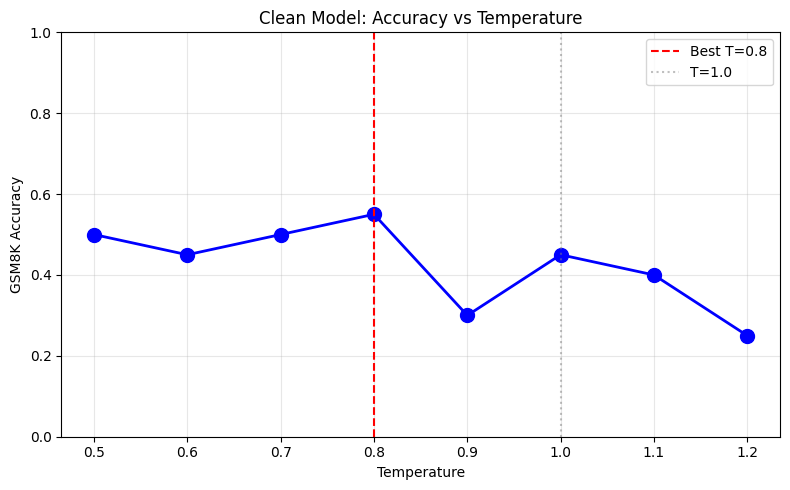

In [9]:
# Find optimal baseline temperature for clean model
baseline_temps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

print("Finding optimal baseline temperature for CLEAN model...")
print("="*60)

baseline_results = {}

for temp in baseline_temps:
    print(f"T={temp}...", end=' ')
    
    acc, _, _ = evaluate_gsm8k_sampling(
        model, tokenizer, test_examples,
        temperature=temp,
        max_new_tokens=1024,
        seed=SEED
    )
    
    baseline_results[temp] = acc
    print(f"Accuracy: {acc:.1%}")

# Find best
T_base = max(baseline_results.keys(), key=lambda t: baseline_results[t])
best_acc = baseline_results[T_base]

print("\n" + "="*60)
print(f"OPTIMAL BASELINE: T_base = {T_base}, Accuracy = {best_acc:.1%}")
print("="*60)

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
temps = list(baseline_results.keys())
accs = [baseline_results[t] for t in temps]

ax.plot(temps, accs, 'bo-', linewidth=2, markersize=10)
ax.axvline(x=T_base, color='red', linestyle='--', label=f'Best T={T_base}')
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5, label='T=1.0')
ax.set_xlabel('Temperature')
ax.set_ylabel('GSM8K Accuracy')
ax.set_title('Clean Model: Accuracy vs Temperature')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('baseline_temperature.png', dpi=150)
plt.show()


In [10]:
# Now compute corrected T* using T_base
print(f"\nUsing T_base = {T_base}")
print("Corrected formula: T* = T_base × √(1 + α)")
print("\nFor noisy evaluation, temperatures will be scaled by T_base.")



Using T_base = 0.8
Corrected formula: T* = T_base × √(1 + α)

For noisy evaluation, temperatures will be scaled by T_base.


In [12]:
import json
# Noisy evaluation
noise_levels_gsm = [0.02, 0.05]
temperatures_gsm = [0.84, 0.91, 1.0, 1.1, 1.2]

gsm8k_results = {'clean': clean_acc}

for noise in noise_levels_gsm:
    print(f"\nNoise level: {noise}")
    
    for temp in temperatures_gsm:
        print(f"  T={temp}...", end=' ')
        
        acc, _, outputs = evaluate_gsm8k_sampling(
            model, tokenizer, test_examples,
            noise_ctx_fn=activation_noise_context,
            noise_scale=noise,
            temperature=temp,
            max_new_tokens=1024,
            seed=SEED
        )
        
        gsm8k_results[(noise, temp)] = acc
        print(f"Accuracy: {acc:.1%}")
        
        # Print first 3 outputs for debugging
        print(f"    Sample outputs (first 3):")
        print(json.dumps(outputs[:3], indent=2))


Noise level: 0.02
  T=0.84...   5/20 done...
  10/20 done...
  15/20 done...
  20/20 done...
Accuracy: 60.0%
    Sample outputs (first 3):
[
  {
    "idx": 0,
    "question": "Janet\u2019s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for ",
    "ground_truth": "18",
    "samples": [
      {
        "response": "First, I need to determine the number of eggs that remain after Janet's consumption and cooking.\n\nJanet's ducks lay 16 eggs each day. She uses 3 eggs for breakfast and bakes muffins with 4 eggs. So, the total eggs consumed and used for baking are 3 plus 4, which equals 7 eggs.\n\nNext, I'll subtract the number of eggs used from the total eggs laid to find out how many are left for sale. 16 minus 7 equals 9 eggs sold daily.\n\nSince each egg is sold for $2, I'll multiply the number of eggs sold by th",
        "pred": "18",
        "correct": true
      }
    ]
  },
  {
    "idx": 1,
    "question": "A robe takes 2 bolts of blue fiber

In [ ]:
# Summary
print("\n" + "="*60)
print("GSM8K RESULTS (with SAMPLING)")
print("="*60)
print(f"\nClean model: {gsm8k_results['clean']:.1%}")
print(f"\n{'Noise':<10}" + ''.join([f'T={t:<8}' for t in temperatures_gsm]) + 'Best T')
print("-"*60)

for noise in noise_levels_gsm:
    row = f"{noise:<10}"
    best_t, best_acc = None, 0
    for temp in temperatures_gsm:
        acc = gsm8k_results[(noise, temp)]
        row += f"{acc:<10.1%}"
        if acc > best_acc:
            best_acc = acc
            best_t = temp
    row += f"{best_t}"
    print(row)

## Conclusions

Fill in after running experiments:

1. **Does T* = √(1+α) work?** 
   - [ ] Yes, T* is optimal
   - [ ] No, different T is better
   - [ ] T doesn't matter much

2. **Sampling vs Greedy:**
   - Temperature only affects sampling!
   - Previous experiments with greedy were invalid

3. **Noise as regularization:**
   - Did low noise improve accuracy?
   - [ ] Yes / [ ] No